In [18]:
import torch
from torch.utils.data import TensorDataset, DataLoader, random_split
from feature_engineering import DataProcessor
#from LSTM import LSTMModel
from RNN import RNNModel
from trainRNN import ModelTrainer
import torch.nn as nn

In [19]:
# Load and preprocess data
dataset_dir = ''
data_processor = DataProcessor(dataset_dir)

# Choose to preprocess data or load saved mappings
preprocess_data = False
char_to_id_file = 'char_to_id.json'
id_to_char_file = 'id_to_char.json'

if preprocess_data:
    ids, char_to_id, id_to_char = data_processor.preprocess()
    data_processor.save_mappings(char_to_id_file, char_to_id, id_to_char_file, id_to_char)
else:
    char_to_id, id_to_char = data_processor.load_mappings(char_to_id_file, id_to_char_file)
print('Mapping loaded')
## Create Dataset sequences with pytorch
#data_processor = DataProcessor(dataset_dir)
dialogue_lines = data_processor.read_dialogue_lines()
text = ' '.join(dialogue_lines.values())
ids = data_processor.text_to_ids(text, char_to_id)
print(len(ids))
dataset = data_processor.create_dataset(ids[:1050])

Mapping loaded
17146310


In [20]:
def train_and_test(input_size,hidden_size,num_layers,num_epochs,batch_size,learning_rate):
  train_loader, val_loader, test_loader=DataProcessor.create_loaders(dataset, 0.8, 0.1, 0.1, 50)
  print('Data Loaded')
  ## Train and Evaluate the model
  # Initialize the RNN model
  input_size = embedding_size = 50
  hidden_size = 256
  num_layers = 2
  vocab_size = len(char_to_id)
  model = RNNModel(input_size, hidden_size, vocab_size, num_layers)

  # Move the model to GPU if available
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  #device = torch.device("cpu")
  model.to(device)

  # Define the loss function, learning rate, and optimizer
  criterion = nn.CrossEntropyLoss()
  learning_rate = 0.001
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  trainer=ModelTrainer(model, train_loader, criterion, optimizer, device)

  print('start training')
  # Training loop

  num_epochs = 5
  for epoch in range(num_epochs):
      print(epoch)
      loss = trainer.train()
      # Evaluate the model on the validation set
      validation_loss = trainer.evaluate(val_loader)
      print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss:.4f}, Validation Loss: {validation_loss:.4f}")

  # Evaluation on test set
  test_loss = trainer.evaluate(test_loader)

  return test_loss


In [21]:
def grid_search(batch_sizes, learning_rates,repeat):
  input_size = 100
  hidden_size = 256
  num_layers = 1
  num_epochs = 10
  results = [[0 for i in range(len(learning_rates))] for j in range((len(batch_sizes)))]

  for i,batch_size in enumerate(batch_sizes):
    for j,learning_rate in enumerate(learning_rates):
      for r in range(repeat):
        results[i][j]+=train_and_test(input_size,hidden_size,num_layers,num_epochs,batch_size,learning_rate)
      results[i][j]/=repeat

  return results



In [24]:
batch_sizes=[10,100,500]
learning_rates=[0.0001,0.001,0.01]
repeat=2
results = grid_search(batch_sizes,learning_rates,repeat)
print(results)

Data Loaded
start training
0
Epoch 1/5, Loss: 3.5978, Validation Loss: 3.0680
1
Epoch 2/5, Loss: 2.8810, Validation Loss: 2.6992
2
Epoch 3/5, Loss: 2.5299, Validation Loss: 2.3224
3
Epoch 4/5, Loss: 2.1281, Validation Loss: 1.8936
4
Epoch 5/5, Loss: 1.6775, Validation Loss: 1.4428
Data Loaded
start training
0
Epoch 1/5, Loss: 3.5675, Validation Loss: 2.9854
1
Epoch 2/5, Loss: 2.8393, Validation Loss: 2.6929
2
Epoch 3/5, Loss: 2.5514, Validation Loss: 2.3724
3
Epoch 4/5, Loss: 2.1690, Validation Loss: 1.9448
4
Epoch 5/5, Loss: 1.7086, Validation Loss: 1.4877
Data Loaded
start training
0
Epoch 1/5, Loss: 3.6362, Validation Loss: 2.9626
1
Epoch 2/5, Loss: 2.7549, Validation Loss: 2.5650
2
Epoch 3/5, Loss: 2.3402, Validation Loss: 2.1419
3
Epoch 4/5, Loss: 1.8839, Validation Loss: 1.6862
4
Epoch 5/5, Loss: 1.4153, Validation Loss: 1.2210
Data Loaded
start training
0
Epoch 1/5, Loss: 3.6273, Validation Loss: 3.0471
1
Epoch 2/5, Loss: 2.8211, Validation Loss: 2.6674
2
Epoch 3/5, Loss: 2.4389

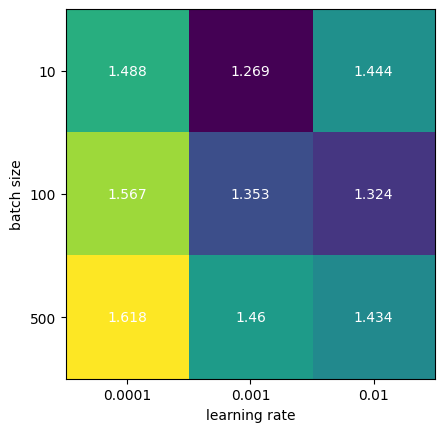

In [25]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
plt.imshow(results, interpolation='nearest')
ax.set_yticks(np.arange(len(batch_sizes)), labels=batch_sizes)
ax.set_xticks(np.arange(len(learning_rates)), labels=learning_rates)
plt.xlabel("learning rate")
plt.ylabel("batch size")
for i in range(len(batch_sizes)):
    for j in range(len(learning_rates)):
        text = ax.text(j, i, round(results[i][j],3),ha="center", va="center", color="w")
plt.show()